客户流失分析可以针对目前老客户进行分类预测。针对航空公司客户信息数据（见demo/data/air_data.csv），可以进行老客户以及客户类型的定义（其中将飞行次数大于6次的客户定义为老客户，已流失客户定义为：第二年飞行次数与第一年飞行次数比例小于50%的客户；准流失客户定义为：第二年飞行次数与第一年飞行次数比例在区间[50%,90%)内的客户；未流失客户定义为：第二年飞行次数与第一年飞行次数比例大于90%的客户）。同时需要选取客户信息中的关键属性如：会员卡级别、客户类型（流失、准流失、未流失）、平均乘机时间间隔、平均折扣率、积分兑换次数、非乘机积分总和、单位里程票价、单位里程积分等。随机选取数据的80%作为分类的训练样本，剩余的20%作为测试样本。构建客户的流失模型，运用模型预测未来客户的类别归属（未流失、准流失，或已流失）

In [1]:
# 导入数据
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
airlineData = pd.read_csv('../data/air_data.csv')
print(airlineData.columns)

Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
       'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 'AGE', 'LOAD_TIME',
       'FLIGHT_COUNT', 'BP_SUM', 'EP_SUM_YR_1', 'EP_SUM_YR_2', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'WEIGHTED_SEG_KM', 'LAST_FLIGHT_DATE',
       'AVG_FLIGHT_COUNT', 'AVG_BP_SUM', 'BEGIN_TO_FIRST', 'LAST_TO_END',
       'AVG_INTERVAL', 'MAX_INTERVAL', 'ADD_POINTS_SUM_YR_1',
       'ADD_POINTS_SUM_YR_2', 'EXCHANGE_COUNT', 'avg_discount',
       'P1Y_Flight_Count', 'L1Y_Flight_Count', 'P1Y_BP_SUM', 'L1Y_BP_SUM',
       'EP_SUM', 'ADD_Point_SUM', 'Eli_Add_Point_Sum', 'L1Y_ELi_Add_Points',
       'Points_Sum', 'L1Y_Points_Sum', 'Ration_L1Y_Flight_Count',
       'Ration_P1Y_Flight_Count', 'Ration_P1Y_BPS', 'Ration_L1Y_BPS',
       'Point_NotFlight'],
      dtype='object')


In [2]:
airlineData['class'] = airlineData['L1Y_Flight_Count'] / airlineData['P1Y_Flight_Count']
# <0.5 已流失 0
# 0.5-0.9 准流失 1
# >0.9 已流失
def classify(x):
    if x < 0.5:
        return 0
    if x>= 0.5 and x<0.9:
        return 1
    else:
        return 2

airlineData['class'] = airlineData['class'].apply(classify)
print(airlineData['class'])

0        2
1        2
2        2
3        1
4        2
        ..
62983    2
62984    2
62985    2
62986    0
62987    0
Name: class, Length: 62988, dtype: int64


In [38]:
# 选择特征
# AVG_INTERVAL
# avg_discount
# BP_SUM
# WEIGHTED_SEG_KM
# EXCHANGE_COUNT
# Points_Sum
# Point_NotFlight
# Eli_Add_Point_Sum
# FLIGHT_COUNT
# SEG_KM_SUM
# EP_SUM
# ADD_Point_SUM

Features = airlineData[['AVG_INTERVAL', 'avg_discount', 'BP_SUM', 'WEIGHTED_SEG_KM', 'EXCHANGE_COUNT', 'Points_Sum', 'Point_NotFlight', 'Eli_Add_Point_Sum', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'EP_SUM', 'ADD_Point_SUM']]

# 选择因变量
Target = airlineData['class']

In [39]:
from sklearn.model_selection import train_test_split
#划分测试集与训练集
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.2, random_state=42)

In [40]:
# 训练随机森林分类
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [41]:
# 评估模型
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred, average='macro'))
print('recall:', recall_score(y_test, y_pred, average='macro'))

accuracy: 0.5960469915859661
precision: 0.54019845574397
recall: 0.46876260901133177


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rfc, Features, Target, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

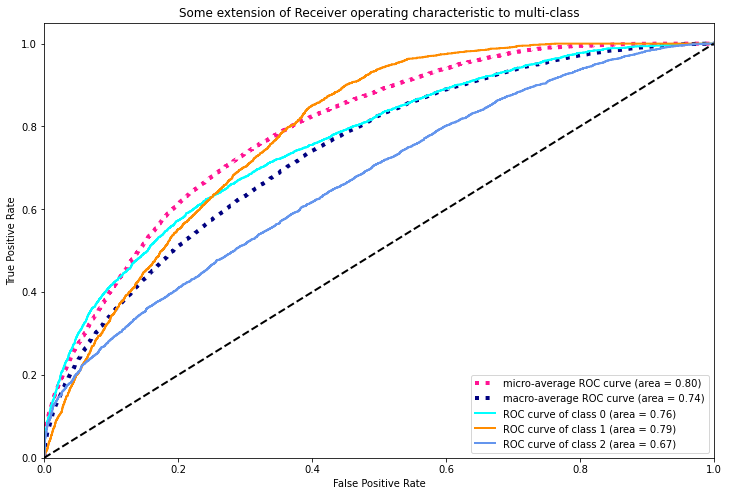

In [7]:
# 画ROC曲线
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle

y_score = rfc.predict_proba(X_test)
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]

# 计算每一类的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算micro-average ROC曲线和AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 计算macro-average ROC曲线和AUC
# 首先汇总所有的FPR
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# 然后再用这些点在所有的ROC曲线上进行插值

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# 最后求平均值并计算AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 画图
plt.figure(figsize=(12, 8))

plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()